# RPPA vs GEX

/Users/arda/Desktop/boeva_lab/cna2gex/nbs/../scripts/data_processing/zscore.py:16: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  zscore_df = merged_df.groupby("cancer_type").apply(lambda x: calculate_zscores(x)).reset_index(drop=True)
/Users/arda/Desktop/boeva_lab/cna2gex/nbs/../scripts/data_processing/zscore.py:16: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior an

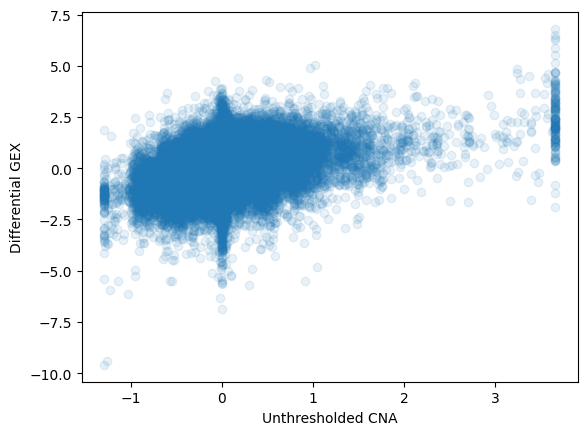

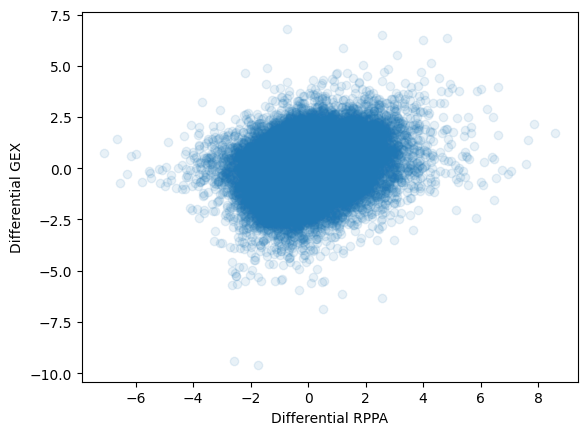

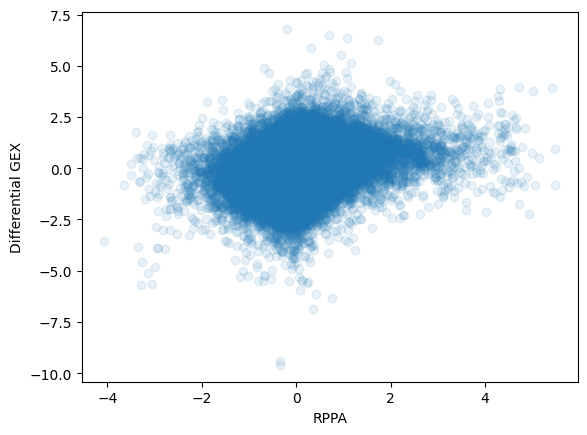

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("../scripts/data_processing/")
from zscore import get_zscore_data

processed_data_dir = "../data/processed"

cancer_type_df = pd.read_csv(os.path.join(processed_data_dir, "cancer_type.tsv"), sep="\t")
cancer_type_df = cancer_type_df[cancer_type_df["cancer_type"] == "blca"]
gex_df = pd.read_csv(os.path.join(processed_data_dir, "gex.tsv"), sep="\t")
rppa_df = pd.read_csv(os.path.join(processed_data_dir, "rppa.tsv"), sep="\t")
unthresholded_cna_df = pd.read_csv(os.path.join(processed_data_dir, "unthresholded_cna.tsv"), sep="\t")

intersecting_sample_id_df = pd.DataFrame(data=set(cancer_type_df["sample_id"]).intersection(
                                              set(gex_df["sample_id"])).intersection(
                                              set(rppa_df["sample_id"])).intersection(
                                              set(unthresholded_cna_df["sample_id"])),
                                         columns=["intersecting_sample_id"]).sort_values(by="intersecting_sample_id")

intersecting_columns = sorted(set(gex_df.columns).intersection(
                              set(rppa_df.columns).intersection(
                              set(unthresholded_cna_df.columns))))

cancer_type_df = pd.merge(intersecting_sample_id_df, cancer_type_df, how="left", left_on="intersecting_sample_id", right_on="sample_id").drop(columns=["intersecting_sample_id"])
gex_df = pd.merge(intersecting_sample_id_df, gex_df, how="left", left_on="intersecting_sample_id", right_on="sample_id")[intersecting_columns]
rppa_df = pd.merge(intersecting_sample_id_df, rppa_df, how="left", left_on="intersecting_sample_id", right_on="sample_id")[intersecting_columns]
unthresholded_cna_df = pd.merge(intersecting_sample_id_df, unthresholded_cna_df, how="left", left_on="intersecting_sample_id", right_on="sample_id")[intersecting_columns]

differential_gex_df = get_zscore_data(gex_df=gex_df, cancer_type_df=cancer_type_df)
differential_rppa_df = get_zscore_data(gex_df=rppa_df, cancer_type_df=cancer_type_df)

unthresholded_cna_1d = unthresholded_cna_df.drop(columns=["sample_id"]).values.ravel()
differential_gex_1d = differential_gex_df.drop(columns=["sample_id"]).values.ravel()
differential_rppa_1d = differential_rppa_df.drop(columns=["sample_id"]).values.ravel()
rppa_1d = rppa_df.drop(columns=["sample_id"]).values.ravel()

plt.scatter(x=unthresholded_cna_1d, y=differential_gex_1d, alpha=0.1)
plt.xlabel("Unthresholded CNA")
plt.ylabel("Differential GEX")
plt.show();

plt.scatter(x=differential_rppa_1d, y=differential_gex_1d, alpha=0.1)
plt.xlabel("Differential RPPA")
plt.ylabel("Differential GEX")
plt.show();

plt.scatter(x=rppa_1d, y=differential_gex_1d, alpha=0.1)
plt.xlabel("RPPA")
plt.ylabel("Differential GEX")
plt.show();



# CNA (thresholded) vs Z-Score (filtered) Box-Plot

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

processed_data_dir = "../data/processed"

thresholded_cna = pd.read_csv(os.path.join(processed_data_dir, "thresholded_cna.tsv"), sep="\t")
gex = pd.read_csv(os.path.join(processed_data_dir, "gex.tsv"), sep="\t")

intersecting_sample_ids = sorted(list(set(thresholded_cna["sample_id"].values).intersection(set(gex["sample_id"].values))))
intersecting_gene_ids = sorted(list(set(thresholded_cna.columns).intersection(set(gex.columns))))

thresholded_cna = thresholded_cna[thresholded_cna["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids].drop(columns=["sample_id"]).values
gex = gex[gex["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids].drop(columns=["sample_id"]).values
z_scores = (gex - gex.mean(axis=0)) / gex.std(axis=0)

thresholded_cna_1d = thresholded_cna.ravel()
z_scores_1d = z_scores.ravel()

thresholded_cna_1d_filtered = [thresholded_cna_1d_i for index, thresholded_cna_1d_i in enumerate(thresholded_cna_1d) if z_scores_1d[index] > -2 and z_scores_1d[index] < 2]
z_scores_1d_filtered = [z_scores_1d_i for index, z_scores_1d_i in enumerate(z_scores_1d) if z_scores_1d[index] > -2 and z_scores_1d[index] < 2]

df = pd.DataFrame.from_dict({"thresholded_cna": thresholded_cna_1d_filtered,
                             "z_score": z_scores_1d_filtered})

df.boxplot(column="z_score", by="thresholded_cna", figsize=(10, 10), fontsize=15)
plt.show();


# Distribution of Pearson Correlation between Median Z-Score (Filtered) and CNA (Thresholded) per Gene

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


processed_data_dir = "../data/processed"

cna = pd.concat(
    [pd.read_csv(os.path.join(processed_data_dir, cancer_type, "thresholded_cna.tsv"), sep="\t") for cancer_type in ["blca"]],
    axis=0
)

gex = pd.concat(
    [pd.read_csv(os.path.join(processed_data_dir, cancer_type, "gex.tsv"), sep="\t") for cancer_type in ["blca"]],
    axis=0
)

intersecting_sample_ids = sorted(list(set(cna["sample_id"].values).intersection(set(gex["sample_id"].values))))
intersecting_gene_ids = sorted(list(set(cna.columns.tolist()).intersection(gex.columns.tolist())))

cna = cna[cna["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids].drop(columns=["sample_id"]).values
gex = gex[gex["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids].drop(columns=["sample_id"]).values
z_scores = (gex - gex.mean(axis=0)) / gex.std(axis=0)

corrs = []
for i in range(cna.shape[1]):
    cna_i = cna[:, i]
    z_scores_i = z_scores[:, i]
    current_df = pd.DataFrame.from_dict({"cna": cna_i, "z_score": z_scores_i})
    current_df = current_df.groupby("cna").agg({"z_score": "median"}).reset_index(drop=False)
    corr = pearsonr(current_df["z_score"].values, current_df["cna"].values)[0]
    corrs.append(corr)

plt.figure(figsize=(10, 6))
plt.hist(corrs, bins=50)
plt.xlabel("Pearson Correlation", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.show();


# Distribution of Pearson Correlation between Median Z-Score (Filtered) and CNA per Gene

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


processed_data_dir = "../data/processed"

cna = pd.concat(
    [pd.read_csv(os.path.join(processed_data_dir, cancer_type, "unthresholded_cna.tsv"), sep="\t") for cancer_type in ["blca"]],
    axis=0
)

gex = pd.concat(
    [pd.read_csv(os.path.join(processed_data_dir, cancer_type, "gex.tsv"), sep="\t") for cancer_type in ["blca"]],
    axis=0
)

intersecting_sample_ids = sorted(list(set(cna["sample_id"].values).intersection(set(gex["sample_id"].values))))
intersecting_gene_ids = sorted(list(set(cna.columns.tolist()).intersection(gex.columns.tolist())))

cna = cna[cna["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids].drop(columns=["sample_id"]).values
gex = gex[gex["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids].drop(columns=["sample_id"]).values
z_scores = (gex - gex.mean(axis=0)) / gex.std(axis=0)

corrs = []
for i in range(cna.shape[1]):
    cna_i = cna[:, i]
    z_scores_i = z_scores[:, i]
    current_df = pd.DataFrame.from_dict({"cna": cna_i, "z_score": z_scores_i})
    corr = pearsonr(current_df["z_score"].values, current_df["cna"].values)[0]
    corrs.append(corr)

plt.figure(figsize=(10, 6))
plt.hist(corrs, bins=50)
plt.xlabel("Pearson Correlation", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.show();


# CNA (not thresholded) vs Z-Score (not filtered) Scatter Plot

In [ ]:
import os
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt


processed_data_dir = "../data/processed"

cna = pd.concat(
    [pd.read_csv(os.path.join(processed_data_dir, cancer_type, "unthresholded_cna.tsv"), sep="\t") for cancer_type in ["blca", "lusc", "ov"]],
    axis=0
)

gex = pd.concat(
    [pd.read_csv(os.path.join(processed_data_dir, cancer_type, "gex.tsv"), sep="\t") for cancer_type in ["blca", "lusc", "ov"]],
    axis=0
)

intersecting_sample_ids = sorted(list(set(cna["sample_id"].values).intersection(set(gex["sample_id"].values))))
intersecting_gene_ids = sorted(list(set(cna.columns.tolist()).intersection(gex.columns.tolist())))

cna = cna[cna["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids].drop(columns=["sample_id"]).values
gex = gex[gex["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids].drop(columns=["sample_id"]).values
z_scores = (gex - gex.mean(axis=0)) / gex.std(axis=0)

cna_1d = cna.ravel()
z_scores_1d = z_scores.ravel()

df = pd.DataFrame.from_dict({"cna": cna_1d, "z_score": z_scores_1d})
pearson_corr, p_value = pearsonr(df["cna"].values, df["z_score"].values)

plt.figure(figsize=(8, 8))
plt.title(f"Pearson Corr: {np.round(pearson_corr, 2)}, P-value: {np.round(p_value, 2)}", fontsize=32)
plt.scatter(x=df["cna"].values, y=df["z_score"].values)
plt.xlabel("CNA", fontsize=28)
plt.ylabel("Z-Score", fontsize=28)
plt.yticks(fontsize=18)
plt.show();



# CNA (thresholded) vs Median Z-Score (not filtered) Scatter Plot

In [ ]:
import os
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit


processed_data_dir = "../data/processed"

cna = pd.concat(
    [pd.read_csv(os.path.join(processed_data_dir, cancer_type, "thresholded_cna.tsv"), sep="\t") for cancer_type in ["blca"]],
    axis=0
)

gex = pd.concat(
    [pd.read_csv(os.path.join(processed_data_dir, cancer_type, "gex.tsv"), sep="\t") for cancer_type in ["blca"]],
    axis=0
)

intersecting_sample_ids = sorted(list(set(cna["sample_id"].values).intersection(set(gex["sample_id"].values))))
intersecting_gene_ids = sorted(list(set(cna.columns.tolist()).intersection(gex.columns.tolist())))

cna = cna[cna["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids].drop(columns=["sample_id"]).values
gex = gex[gex["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids].drop(columns=["sample_id"]).values
z_scores = (gex - gex.mean(axis=0)) / gex.std(axis=0)

cna_1d = cna.ravel()
z_scores_1d = z_scores.ravel()

df = pd.DataFrame.from_dict({"cna": cna_1d, "z_score": z_scores_1d})
df = df.groupby("cna").agg({"z_score": "median"}).reset_index(drop=False)
pearson_corr, p_value = pearsonr(df["cna"].values, df["z_score"].values)

b, m = polyfit(df["cna"].values, df["z_score"].values, 1)

plt.figure(figsize=(8, 8))
plt.title(f"Pearson Corr: {np.round(pearson_corr, 2)}, P-value: {np.round(p_value, 2)}", fontsize=32)
plt.scatter(x=df["cna"].values, y=df["z_score"].values)
plt.plot(df["cna"].values, b + m * df["cna"].values, '-', color="red")
plt.xlabel("Thresholded CNA", fontsize=28)
plt.ylabel("Median Z-Score", fontsize=28)
plt.xticks([-2, -1, 0, 1, 2], fontsize=18)
plt.yticks(fontsize=18)
plt.show();


# Check whether there is a correlation between best predicted genes and AUGs/DDGs

In [ ]:
import os
import pandas as pd
from collections import defaultdict
from scipy.stats import pearsonr

processed_data_dir = "../data/processed"
checkpoint_dir = "../checkpoints/1668990938_bcc52ffdd58647c194c4c000ffaa6e61"

cna = pd.read_csv(os.path.join(processed_data_dir, "blca", "cna_thresholded.tsv"), sep="\t")
gex = pd.read_csv(os.path.join(processed_data_dir, "blca", "gex.tsv"), sep="\t")

ground_truths = pd.read_csv(os.path.join(checkpoint_dir, "test_results", "ground_truths.tsv"), sep="\t")
predictions = pd.read_csv(os.path.join(checkpoint_dir, "test_results", "predictions.tsv"), sep="\t")

intersecting_sample_ids = sorted(list(set(cna["sample_id"].values).intersection(set(gex["sample_id"].values))))
intersecting_gene_ids = sorted(list(set(cna.columns).intersection(set(gex.columns))))
intersecting_gene_ids.remove("sample_id")

cna = cna[cna["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids].values
gex = gex[gex["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids].values
z_scores = (gex - gex.mean(axis=0)) / gex.std(axis=0)

gene_id_state_mapping = defaultdict(lambda: {
    "cna_aug_or_ddg": 0,
    "all": 0
})

for i in range(cna.shape[0]):
    for j, gene_id in enumerate(intersecting_gene_ids):
        current_cna = cna[i][j]
        current_z_score = z_scores[i][j]

        if (current_cna > 0 and current_z_score > 0) or (current_cna < 0 and current_z_score < 0):
            gene_id_state_mapping[gene_id]["cna_aug_or_ddg"] += 1
        
        gene_id_state_mapping[gene_id]["all"] += 1

for gene_id, gene_state in gene_id_state_mapping.items():
    gene_id_state_mapping[gene_id] = gene_id_state_mapping[gene_id]["cna_aug_or_ddg"] / gene_id_state_mapping[gene_id]["all"]

gene_predictabilities = pd.DataFrame.from_dict({"gene_id": list(gene_id_state_mapping.keys()), "gene_predictability": list(gene_id_state_mapping.values())})

gene_prediction_correlations = []
for gene_id in ground_truths.columns:
    gene_prediction_correlations.append((gene_id, pearsonr(ground_truths[gene_id], predictions[gene_id])[0]))

gene_prediction_correlations = pd.DataFrame(data=gene_prediction_correlations, columns=["gene_id", "gene_prediction_correlation"])

merged_df = pd.merge(left=gene_predictabilities, right=gene_prediction_correlations, how="inner", on="gene_id")

pearsonr(x=merged_df["gene_predictability"].values, y=merged_df["gene_prediction_correlation"].values)[0]



In [ ]:
import os
import numpy as np
from collections import defaultdict
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit


processed_data_dir = "../data/processed"

cna = pd.concat(
    [pd.read_csv(os.path.join(processed_data_dir, cancer_type, "cna_thresholded.tsv"), sep="\t") for cancer_type in ["blca"]],
    axis=0
)

gex = pd.concat(
    [pd.read_csv(os.path.join(processed_data_dir, cancer_type, "gex.tsv"), sep="\t") for cancer_type in ["blca"]],
    axis=0
)

intersecting_sample_ids = sorted(list(set(cna["sample_id"].values).intersection(set(gex["sample_id"].values))))
intersecting_gene_ids = sorted(list(set(cna.columns).intersection(set(gex.columns))))
intersecting_gene_ids.remove("sample_id")

cna = cna[cna["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids]
gex = gex[gex["sample_id"].isin(intersecting_sample_ids)][intersecting_gene_ids]
z_scores = ((gex - gex.mean(axis=0)) / gex.std(axis=0))

gene_id_state_mapping = defaultdict(lambda: {
    "cna_amplified_gex_upregulated": 0,
    "cna_amplified_gex_downregulated": 0,
    "cna_amplified_gex_no_change": 0,

    "cna_no_change_gex_upregulated": 0,
    "cna_no_change_gex_downregulated": 0,
    "cna_no_change_gex_no_change": 0,

    "cna_deleted_gex_upregulated": 0,
    "cna_deleted_gex_downregulated": 0,
    "cna_deleted_gex_no_change": 0,
})

for gene_id in intersecting_gene_ids:
    cna_i = cna[gene_id].values.ravel()
    z_scores_i = z_scores[gene_id].values.ravel()

    for j in range(len(cna_i)):
        cna_ij = cna_i[j]
        z_scores_ij = z_scores_i[j]
        if cna_ij > 0:
            if z_scores_ij > 0:
                gene_id_state_mapping[gene_id]["cna_amplified_gex_upregulated"] += 1
            elif z_scores_ij < 0:
                gene_id_state_mapping[gene_id]["cna_amplified_gex_downregulated"] += 1
            elif z_scores_ij == 0:
                gene_id_state_mapping[gene_id]["cna_amplified_gex_no_change"] += 1
        elif cna_ij < 0:
            if z_scores_ij > 0:
                gene_id_state_mapping[gene_id]["cna_deleted_gex_upregulated"] += 1
            elif z_scores_ij < 0:
                gene_id_state_mapping[gene_id]["cna_deleted_gex_downregulated"] += 1
            elif z_scores_ij == 0:
                gene_id_state_mapping[gene_id]["cna_deleted_gex_no_change"] += 1
        else:
            if z_scores_ij > 0:
                gene_id_state_mapping[gene_id]["cna_no_change_gex_upregulated"] += 1
            elif z_scores_ij < 0:
                gene_id_state_mapping[gene_id]["cna_no_change_gex_downregulated"] += 1
            elif z_scores_ij == 0:
                gene_id_state_mapping[gene_id]["cna_no_change_gex_no_change"] += 1

data = []
for gene_id, gene_states_dict in gene_id_state_mapping.items():
    data.append((gene_id,
                 gene_states_dict["cna_amplified_gex_upregulated"],
                 gene_states_dict["cna_amplified_gex_downregulated"],
                 gene_states_dict["cna_amplified_gex_no_change"],
                 gene_states_dict["cna_deleted_gex_upregulated"],
                 gene_states_dict["cna_deleted_gex_downregulated"],
                 gene_states_dict["cna_deleted_gex_no_change"],
                 gene_states_dict["cna_no_change_gex_upregulated"],
                 gene_states_dict["cna_no_change_gex_downregulated"],
                 gene_states_dict["cna_no_change_gex_no_change"]))

gene_predictabilities = pd.DataFrame(data=data, columns=["gene_id",
                                                         "cna_amplified_gex_upregulated",
                                                         "cna_amplified_gex_downregulated",
                                                         "cna_amplified_gex_no_change",
                                                         "cna_deleted_gex_upregulated",
                                                         "cna_deleted_gex_downregulated",
                                                         "cna_deleted_gex_no_change",
                                                         "cna_no_change_gex_upregulated",
                                                         "cna_no_change_gex_downregulated",
                                                         "cna_no_change_gex_no_change"])
gene_predictabilities = gene_predictabilities.set_index("gene_id")
sum_rows = gene_predictabilities.values.sum(axis=1).reshape(-1, 1)

gene_predictabilities = pd.DataFrame(data=gene_predictabilities.values / sum_rows, columns=gene_predictabilities.columns, index=gene_predictabilities.index.values)

gene_predictabilities["gene_predictability"] = gene_predictabilities["cna_amplified_gex_upregulated"].values + gene_predictabilities["cna_deleted_gex_downregulated"].values
gene_predictabilities = gene_predictabilities[["gene_predictability"]].sort_values(by="gene_predictability", ascending=False)

gene_predictabilities


In [ ]:
import os
import pandas as pd
from scipy.stats import pearsonr

checkpoint_dir = "../checkpoints/1668991987_c365f1939ced43f2bea10f07f5a6e4c1"

ground_truths = pd.read_csv(os.path.join(checkpoint_dir, "test_results", "ground_truths.tsv"), sep="\t")
predictions = pd.read_csv(os.path.join(checkpoint_dir, "test_results", "predictions.tsv"), sep="\t")

data = []
for entrezgene_id in ground_truths.columns:
    gene_corr = pearsonr(x=ground_truths[entrezgene_id].values, y=predictions[entrezgene_id].values)[0]
    data.append((entrezgene_id, gene_corr))
gene_prediction_correlations = pd.DataFrame(data=data, columns=["entrezgene_id", "gene_prediction_correlation"])
gene_prediction_correlations = gene_prediction_correlations.set_index("entrezgene_id")
gene_prediction_correlations


In [ ]:
merged_df = pd.merge(left=gene_predictabilities, right=gene_prediction_correlations, how="inner", left_index=True, right_index=True)
pearsonr(x=merged_df["gene_predictability"].values, y=merged_df["gene_prediction_correlation"].values)[0]


In [ ]:
import matplotlib.pyplot as plt

plt.hist(cna)

In [ ]:
161/(161+271)